# Quick Start with LangGraph

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

* Answer common questions by searching the web
* Maintain conversation state across calls
* Route complex queries to a human for review
* Use custom state to control its behavior
* Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_openai

Next, set your API keys:

In [5]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY") # "OPENAI_API_KEY"

OPENAI_API_KEY: ··········


(Encouraged) LangSmith makes it a lot easier to see what's going on "under the hood."

In [6]:
_set_env("LANGSMITH_API_KEY") #LANGSMITH_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

LANGSMITH_API_KEY: ··········


## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [81]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### **`Note`**:
The first thing you do when you define a graph is define the State of the graph. The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. In our example State is a TypedDict with a single key: messages. The messages key is annotated with the add_messages reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it. State keys without an annotation will be overwritten by each update, storing the most recent value. Check out this [conceptual guide](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) to learn more about state, reducers and other low-level concepts.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [82]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our State will append the llm's response messages to whatever `messages` are already in the state.

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [8]:
graph_builder.add_edge(START, "chatbot")


Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [9]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.

In [10]:
graph = graph_builder.compile()

You can visualize the graph using the get_graph method and one of the "draw" methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

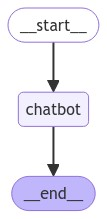

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot!

**`Tip`**: You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [12]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: Hi! how are you?
Assistant: Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?
User: Mmmm, wassapppp?
Assistant: Hey! Not much, just here and ready to chat. What’s up with you?
User: I am good, can you help me with mmm, mmm, hmmm
Assistant: Of course! It sounds like you might be uncertain or pondering something. Could you provide a bit more context or clarify what you need help with? Whether it's a question, topic, or any specific issue, I'm here to assist!
User: quit
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/), and set your TAVILY_API_KEY.

In [7]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [8]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


Next, define the tool:

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'}]

In [17]:
tool.invoke("how many gold medals USA team won at Paris olympics?")

[{'url': 'https://olympics.com/en/news/olympic-games-paris-2024-all-u-s-medal-winners-full-list',
  'content': 'Know each U.S. medal winner at Paris 2024. The United States arrived in the French capital with a contingent of nearly 600 athletes for the Olympic Games Paris 2024 from 26 July to 11 August.. Team USA came into the Games looking to exceed their haul from Tokyo 2020 in 2021 where it won 39 gold, 41 silver, and 33 bronze medals for a total of 113 medals. . The North Americans have broken ...'},
 {'url': 'https://www.freep.com/story/sports/olympics/2024/08/10/usa-basketball-gold-medal-count-2024-paris-olympics/74432160007/',
  'content': 'Heading into the 2024 Paris Olympics, USA Basketball has won an impressive 16 gold medals at the Olympics. The first gold medal for the United States came in the 1936 Berlin Olympics.'}]

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [20]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(model="gpt-4o-mini")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

In [21]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that `edges` route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and "__end__" if not.

Later, we will replace this with the prebuilt `tools_condition` to be more concise, but implementing it ourselves first makes things more clear.

In [22]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Notice that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt tools_condition, our function returns the "__end__" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

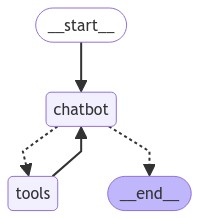

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: Hi, can you tell me about rceent Paris Olympics news?
Assistant: 
Assistant: [{"url": "https://www.nytimes.com/athletic/live-blogs/paris-olympics-2024-live-updates-day-14-scores-results/R5EEaqToFGOK/", "content": "Paris Olympics 2024 \u2014 Day 14 latest. Sha'Carri Richardson won her first Olympic gold medal today, bringing the Americans from behind with a stunning anchor leg to lead her nation to glory in ..."}, {"url": "https://olympics.com/en/paris-2024/news-all", "content": "Kelvin Kiptum's memory lingers over Paris 2024 marathons. Volleyball. USA beat Italy in straight sets to clinch men's bronze. Rhythmic Gymnastics. Germany's Darja Varfolomeev clinches individual all-around gold on Olympic debut. Breaking. With boom, bass and Snoop Dogg, breaking opens at Paris 2024. Table Tennis."}]
Assistant: Here are some recent updates from the Paris Olympics 2024:

1. **Sha'Carri Richardson's Victory**: Sha'Carri Richardson won her first Olympic gold medal, leading the American team t

## Full Code so far!

The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt `ToolNode`, and our `route_tools` condition with the prebuilt `tools_condition`

In [9]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a checkpointer when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a `MemorySaver` checkpointer.

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Notice we're using an `in-memory checkpointer`. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [11]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Finally, compile the graph with the provided checkpointer.

In [12]:
graph = graph_builder.compile(checkpointer=memory)

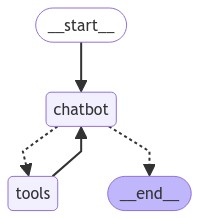

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a `thread` to use as the key for this conversation.

In [14]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [15]:
user_input = "Hi there! My name is Roma."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Roma.
================================== Ai Message ==================================

Hello Roma! How can I assist you today?


**`Note`**: The config was provided as the second positional argument when calling our graph. It importantly is not nested within the graph inputs ({'messages': []}).

Let's ask a followup: see if it remembers your name.

In [16]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Roma! How can I help you today?


Notice that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.

Don't believe me? Try this using a different config.

In [17]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information, including names, from previous interactions. However, you can share your name with me now if you'd like!


Notice that the only change we've made is to modify the thread_id in the config. See this call's LangSmith trace for comparison.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's state for a given config at any time, call `get_state(config)`.

In [18]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Roma.', id='768bf8ff-df36-4996-966b-a9a49f325f52'), AIMessage(content='Hello Roma! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 87, 'total_tokens': 98}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprobs': None}, id='run-8d4f0629-69cf-4e7a-adae-2d0ac4e8b860-0', usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98}), HumanMessage(content='Remember my name?', id='03c4565a-c4b1-46e6-a0b0-df3bfbe6c7b7'), AIMessage(content='Yes, I remember your name, Roma! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 109, 'total_tokens': 126}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'stop', 'logprob

In [19]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an __end__ state, so next is empty.

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [21]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, compile the graph, specifying to `interrupt_before` the action node.

In [22]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [23]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Ud9FhptBOLbfqdxAb1b4lC36)
 Call ID: call_Ud9FhptBOLbfqdxAb1b4lC36
  Args:
    query: LangGraph


Let's inspect the graph state to confirm it worked.



In [24]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**`Notice`** that unlike last time, the "next" node is set to 'action'. We've interrupted here! Let's check the tool invocation.

In [25]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_Ud9FhptBOLbfqdxAb1b4lC36',
  'type': 'tool_call'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in None will just let the graph continue where it left off, without adding anything new to the state.

In [26]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "LangGraph is a framework for building agentic and multi-agent applications with LLMs, and LangGraph Cloud is a scalable and reliable infrastructure for deploying them. Learn how LangGraph helps you design, debug, and monitor complex agentic workflows with LLMs."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}]
================================== Ai Message ==================================

Here are some resources about LangGraph:

1. **LangGraph Overview**:
   - **Description**: LangGraph is a framework designed for building agentic and multi-agent applications usin

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you manually update state! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [27]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [28]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_TMrY5T9VERr4jEOus8qTE4uy)
 Call ID: call_TMrY5T9VERr4jEOus8qTE4uy
  Args:
    query: LangGraph


So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [30]:
from langchain_core.messages import AIMessage
import json

from langchain_core.messages import ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b8afb3dd-a92d-46d7-97c9-6b6aba7e7b89', tool_call_id='call_TMrY5T9VERr4jEOus8qTE4uy'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='1998b258-92cb-4a6d-aaf5-24e9edaf0aaa')]


Now the graph is complete, since we've provided the final response message! Since state updates simulate a graph step, they even generate corresponding traces. Inspec the LangSmith trace of the update_state call above to see what's going on.

Notice that our new messages are appended to the messages already in the state. Remember how we defined the State type?

In [31]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

We annotated messages with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [32]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef57de8-81c0-6856-8003-57f5c9d635b6'}}

 Notice from the trace that the graph continues into the `tools_condition` edge. We just told the graph to treat the update `as_node`="chatbot". If we follow the diagram below and start from the chatbot node, we naturally end up in the `tools_condition` edge and then `__end__` since our updated message lacks tool calls.

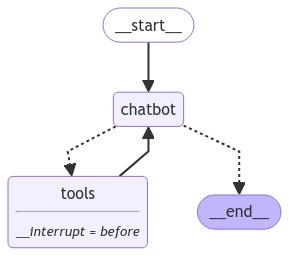

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [34]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b8afb3dd-a92d-46d7-97c9-6b6aba7e7b89', tool_call_id='call_TMrY5T9VERr4jEOus8qTE4uy'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='1998b258-92cb-4a6d-aaf5-24e9edaf0aaa'), AIMessage(content="I'm an AI expert!", id='831ca7d7-77bb-4228-a83b-0716e22cf36f')]
()


Notice: that we've continued to add AI messages to the state. Since we are acting as the chatbot and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

### What if you want to overwrite existing messages?
The `add_messages` function we used to annotate our graph's State above controls how updates are made to the `messages` key. This function looks at any message IDs in the new messages list. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [35]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_hAf3FVhABQwNAptexe6RD53H)
 Call ID: call_hAf3FVhABQwNAptexe6RD53H
  Args:
    query: LangGraph


**`Next`**, let's update the tool invocation for our agent. Maybe we want to search for `human-in-the-loop` workflows in particular.

In [36]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-7374c3e6-66bd-4c8d-be70-a8910898073f-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_hAf3FVhABQwNAptexe6RD53H', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_hAf3FVhABQwNAptexe6RD53H', 'type': 'tool_call'}
Message ID run-7374c3e6-66bd-4c8d-be70-a8910898073f-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_hAf3FVhABQwNAptexe6RD53H',
  'type': 'tool_call'}]

Notice that we've modified the AI's tool invocation to search for "LangGraph human-in-the-loop workflow" instead of the simple "LangGraph".

Resume the graph by streaming with an input of `None` and the existing config

In [37]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an LLM (Language Model) permission to ..."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features. LangGraph is inspired by Pregel and Apache Beam."}]
================================== Ai Message ==================================

Here's what I found about LangGraph:

1. **Overview**: LangGraph is a low-level framework designed for building applications with fine-grained control ove

**`Notice`** that now the graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the modified state.

In [38]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

Yes, you're learning about LangGraph. If you have specific aspects you'd like to explore further or particular questions, feel free to let me know!


You've used `interrupt_before` and `update_state` to manually modify the state as a part of a `human-in-the-loop` workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...]) (or interrupt_after)` if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph always interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough` "human" node`, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated State

In [56]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

In [57]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

Next, define the chatbot node. The primary modification here is flip the ask_human flag if we see that the chat bot has invoked the RequestAssistance flag.

In [58]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [59]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Next, create the "`human" node`. This node function is mostly a placeholder in our graph that will trigger an `interrupt`. If the human does not manually update the state during the interrupt, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [60]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The `select_next_node` will route to the human node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the chatbot has responded with any `tool_calls` in its response message. If so, it routes to the action node. Otherwise, it `ends` the graph.

In [61]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to always flow from node `a->b` whenever `a` finishes executing.

In [62]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

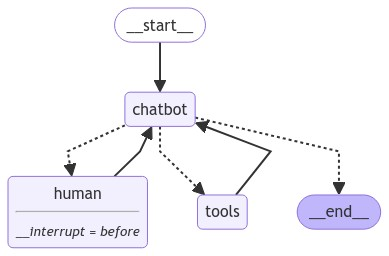

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human `(chatbot->select->human)`, invoke the search engine tool `(chatbot->select->action)`, or directly respond `(chatbot->select->end)`. Once an action or request has been made, the graph will transition back to the `chatbot node` to continue operations.

Let's see this graph in action. We will request for **expert assistance** to illustrate our graph.

In [64]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_DZwmfucxJkzjthErBknVbybi)
 Call ID: call_DZwmfucxJkzjthErBknVbybi
  Args:
    request: I need expert guidance for building an AI agent. Specifically, I'm looking for advice on architecture, necessary technologies, and best practices in the development process.



Notice: the LLM has invoked the "RequestAssistance" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [65]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed interrupted before the '`human' node`. We can act as the "**expert**" in this scenario and manually update the state by adding a new `ToolMessage` with our input.

Next, respond to the chatbot's request by:

1. Creating a `ToolMessage` with our response. This will be passed back to the chatbot.
2. Calling `update_state` to manually update the graph state.

In [66]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef57e76-b510-6db1-8002-552dce0e27bd'}}

You can inspect the state to confirm our response was added.

In [67]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='e54962e8-5f6e-4b10-b3d0-d7e7e0981f9f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DZwmfucxJkzjthErBknVbybi', 'function': {'arguments': '{"request":"I need expert guidance for building an AI agent. Specifically, I\'m looking for advice on architecture, necessary technologies, and best practices in the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 160, 'total_tokens': 204}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_507c9469a1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c4b0517e-d847-41fe-9ae4-cac63bcaf2c9-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': "I need expert guidance for building an AI agent. Specifically, I'm looking for advice on architecture, neces

Next, **resume** the graph by invoking it with None as the inputs.

In [68]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I have requested expert assistance for you. They recommend using LangGraph to build your AI agent, as it is more reliable and extensible compared to simple autonomous agents. If you have any specific questions about LangGraph or the development process, feel free to ask!


**`Notice`** that the chat bot has incorporated the updated state in its final response. Since everything was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add `memory` and a `human-in-the-loop` to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and `"branch off"` to explore a separate outcome? Or what if you want users to be able to `"rewind"` your assistant's work to fix some mistakes or try a different strategy (**common in applications like autonomous software engineers**)?

You can create both of these experiences and more using LangGraph's built-in `"time travel"` functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make any changes from before:

### Full Code so Far!

In [69]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

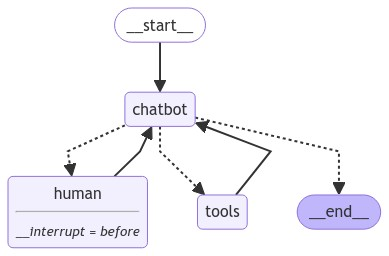

In [70]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [71]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_aC7UcSemLl7ksINRyhjpkRoG)
 Call ID: call_aC7UcSemLl7ksINRyhjpkRoG
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "LangGraph is a framework for building language agents as graphs. Learn how to use LangGraph to create chatbots, code assistants, planning agents, reflection agents, and more with these notebooks."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, int

In [72]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph could lead to some innovative applications. If you need any assistance, resources, or ideas as you work on your project, feel free to reach out. Good luck with your development!


Now that we've had the agent take a couple steps, we can replay the `full state history` to see everything that occurred.

In [77]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 5:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


Notice that checkpoints are saved for every step of the graph. This **spans invocations** so you can rewind across a full thread's history. We've picked out `to_replay` as a state to `resume` from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the `action` node next.

In [78]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef57e91-e617-6cc9-8005-2ae6c3b39736'}}


Notice that the checkpoint's config `(to_replay.config) `contains a `thread_ts` timestamp. Providing this `thread_ts` value tells LangGraph's checkpointer to load the state from that moment in time. Let's try it below:

In [79]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph could lead to some innovative applications. If you need any assistance, resources, or ideas as you work on your project, feel free to reach out. Good luck with your development!


## Congrats! That's the end of tutorial! Hope you enjoyed!!!